In [1]:
# Arbol de decisiones, vamos a predecir si una canción llega al top 1 de billboard o no.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [3]:
# Cargar los datos
artists_billboard = pd.read_csv("artists_billboard_fix3.csv")

In [4]:
# Analisis exploratorio de los datos
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [5]:
artists_billboard.shape

(635, 11)

In [6]:
#Cuantas canciones tengo de cada clases
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

In [9]:
# Preparar los datos

# Función para calcular las edades en las que estuvieron en el billboard
def calcula_edad(anio, cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio == 0.0:
        return None
    return int(momento) - anio


In [10]:
artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']),axis=1)

In [11]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,NaN


In [12]:
age_avg = artists_billboard['edad_en_billboard'].mean() 
age_std = artists_billboard['edad_en_billboard'].std() 

In [13]:
age_avg

30.10282258064516

In [14]:
age_std

8.40078832861513

In [15]:
# Asignar valores al azar en el rango media-std  media +std que es de 21 a 37 aprox
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum() 
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

In [16]:
conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])
artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list 
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)

In [17]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26


In [18]:
#Voy a empezara mappear el mood para que sean variables categóricas
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( 
    {
        'Energizing': 6,
        'Empowering': 6,
        'Cool': 5,
        'Yearning': 4,
        'Excited': 5,  
        'Defiant': 3,
        'Sensual': 2,
        'Gritty': 3, 
        'Sophisticated': 4,
        'Aggressive': 4, 
        'Fiery': 4,
        'Urgent': 3, 
        'Rowdy': 4,
        'Sentimental': 4, 
        'Easygoing': 1, 
        'Melancholy': 4, 
        'Romantic': 2,
        'Peaceful': 1,
        'Brooding': 4, 
        'Upbeat': 5, 
        'Stirring': 5,
        'Lively': 5, 
        'Other': 0,
        '':0
    }).astype(int)

In [19]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26,4


In [20]:
#Mapeo del tempo
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 
                                                                     'Medium Tempo': 2, 
                                                                     'Slow Tempo': 1, 
                                                                     '': 0} ).astype(int)

In [21]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4,2
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6,2
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5,2
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4,2
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26,4,2


In [22]:
# Mapeo del genero
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( 
    {'Urban': 4,
    'Pop': 3,
    'Traditional': 2, 
    'Alternative & Punk': 1,
    'Electronica': 1, 
    'Rock': 1, 
    'Soundtrack': 0, 
    'Jazz': 0, 
    'Other':0,
    '':0}
).astype(int)

In [23]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded,genreEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4,2,2
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6,2,3
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5,2,4
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4,2,1
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26,4,2,2


In [24]:
#Mapeo del tipo de artista
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 
                                                                                 'Male': 3, 
                                                                                 'Mixed': 1, 
                                                                                 '': 0} ).astype(int)

In [25]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4,2,2,3
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6,2,3,2
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5,2,4,1
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4,2,1,3
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26,4,2,2,2


In [26]:
#Mapeo de la edad
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded'] = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1 
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2 
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

In [27]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4,2,2,3,3.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6,2,3,2,1.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5,2,4,1,0.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4,2,1,3,1.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26,4,2,2,2,1.0


In [28]:
#Mapeo de duracion en segundos
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded'] = 0 
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1 
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2 
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3 
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4 
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5 
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

In [29]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4,2,2,3,3.0,2.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6,2,3,2,1.0,6.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5,2,4,1,0.0,3.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4,2,1,3,1.0,2.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0,26,4,2,2,2,1.0,3.0


In [30]:
# Tirar (drop) todas las columnas que no necesito
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard'] 

In [31]:
artists_encoded = artists_billboard.drop(drop_elements, axis = 1) 

In [32]:
artists_encoded.head()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,4,2,2,3,3.0,2.0
1,0,6,2,3,2,1.0,6.0
2,1,5,2,4,1,0.0,3.0
3,0,4,2,1,3,1.0,2.0
4,0,4,2,2,2,1.0,3.0


In [33]:
# Entrenar el modelo con todo lo que conlleva el arbol de decisiones
# Encontrar la profundidad máxima de mi árbol
cv = KFold(n_splits=10)
accuracies = []
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

In [34]:
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_split=20,
        min_samples_leaf=5,
        max_depth = depth,
        class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded): 
        f_train = artists_encoded.loc[train_fold]
        f_valid = artists_encoded.loc[valid_fold]
        model = tree_model.fit(X = f_train.drop(['top'], axis=1), y = f_train["top"])
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), y = f_valid["top"]) 
        # calculamos la precision con el segmento de validacion 
        fold_accuracy.append(valid_acc)
    avg = sum(fold_accuracy)/len(fold_accuracy) 
    accuracies.append(avg)

In [35]:
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556126
         3          0.564038
         4          0.634722
         5          0.588914
         6          0.622049
         7          0.631300


In [36]:
# Creando el modelo
decision_tree = tree.DecisionTreeClassifier(criterion = "entropy",
                                            min_samples_split = 20,
                                            min_samples_leaf = 5,
                                            max_depth = 4,
                                            class_weight = {1:3.5})

In [40]:
# Crear arrays de entrenamiento y las etiquetas de indican si llegó al top o no
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis = 1).values

In [41]:
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={1: 3.5}, criterion='entropy', max_depth=4,
                       min_samples_leaf=5, min_samples_split=20)

In [42]:
with open(r"tree1.dot", 'w') as f:
    f = tree.export_graphviz(decision_tree, 
                             out_file=f,
                             max_depth = 7, 
                             impurity = True, 
                             feature_names = list(artists_encoded.drop(['top'], axis=1)),
                             class_names = ['No', 'Si'],
                             rounded = True, 
                             filled= True )

In [43]:
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

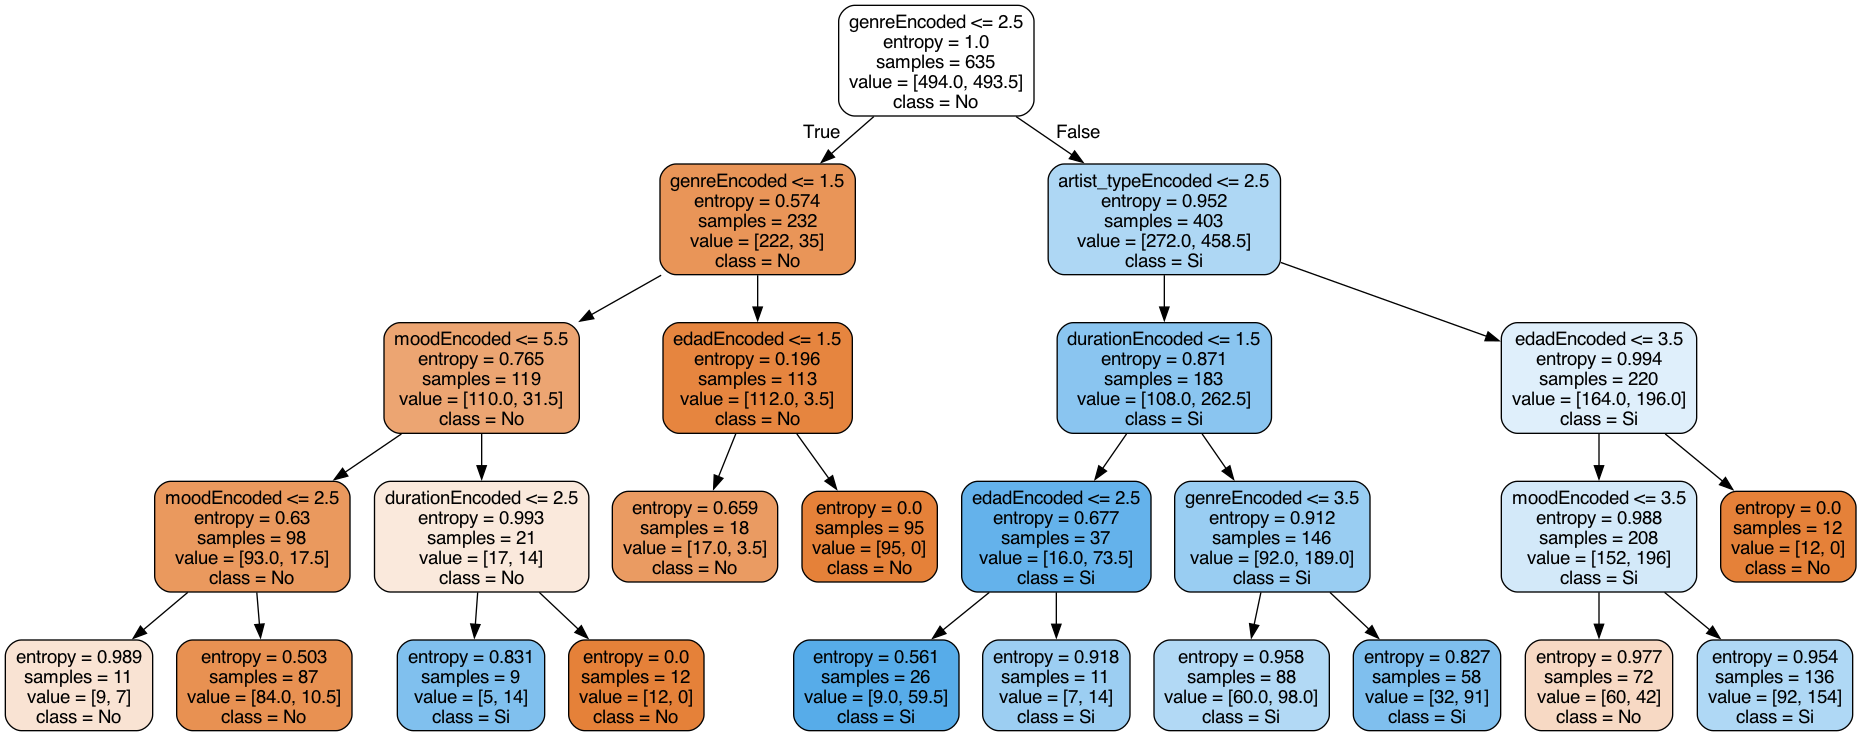

In [45]:
PImage("tree1.png")

In [46]:
# Prediccion para la canción Havanna de Camila Cabello que SI llegó al top 1
x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded '))
x_test.loc[0] = (1,5,2,4,1,0,3)

In [47]:
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))

/Users/haydeml/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [48]:
print("Prediccion: " + str(y_pred))

Prediccion: [1]


In [49]:
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(y_proba[0][y_pred]* 100)+"%")

Probabilidad de Acierto: [73.98373984]%


/Users/haydeml/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [50]:
# Prediccion para la canción Believer de Imagine Dragons que NO llegó al top 1
x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded '))
x_test.loc[0] = (0,4,2,1,3,2,3)

In [52]:
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))

Prediccion: [0]


/Users/haydeml/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [54]:
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(y_proba[0][y_pred]* 100)+"%")

Probabilidad de Acierto: [88.88888889]%


/Users/haydeml/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


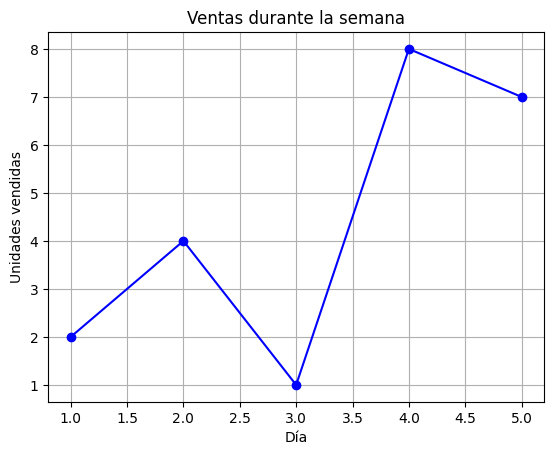

In [56]:


x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 8, 7]

plt.plot(x, y, marker='o', color='blue')
plt.title("Ventas durante la semana")
plt.xlabel("Día")
plt.ylabel("Unidades vendidas")
plt.grid(True)
plt.show()